In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


In [26]:
# Load the data
customers_df = pd.read_csv('Customers.csv')  # Replace with your actual file path
transactions_df = pd.read_csv('Transactions.csv')  # Replace with your actual file path

# Display first few rows to understand the data
print(customers_df.head())
print(transactions_df.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


In [27]:
# Merge customer profile data with transaction data based on 'CustomerID'
data = pd.merge(customers_df, transactions_df, on='CustomerID')

# Handle missing values:
# 1. Fill missing values for numeric columns (e.g., mean)
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# 2. For categorical columns (e.g., CustomerID), you can fill missing values with the mode
categorical_columns = data.select_dtypes(include=[object]).columns
for col in categorical_columns:
    data[col] = data[col].fillna(data[col].mode()[0])  # Fill with mode (most frequent value)

# Display first few rows after merging and filling missing values
print(data.head())



  CustomerID      CustomerName         Region  SignupDate TransactionID  \
0      C0001  Lawrence Carroll  South America  2022-07-10        T00015   
1      C0001  Lawrence Carroll  South America  2022-07-10        T00932   
2      C0001  Lawrence Carroll  South America  2022-07-10        T00085   
3      C0001  Lawrence Carroll  South America  2022-07-10        T00445   
4      C0001  Lawrence Carroll  South America  2022-07-10        T00436   

  ProductID      TransactionDate  Quantity  TotalValue   Price  
0      P054  2024-01-19 03:12:55         2      114.60   57.30  
1      P022  2024-09-17 09:01:18         3      412.62  137.54  
2      P096  2024-04-08 00:01:00         2      614.94  307.47  
3      P083  2024-05-07 03:11:44         2      911.44  455.72  
4      P029  2024-11-02 17:04:16         3     1300.92  433.64  


In [28]:
# Scale the numerical features using StandardScaler
scaler = StandardScaler()
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns
data_scaled = scaler.fit_transform(data[numerical_features])

# Check scaled data
print(data_scaled[:5])  # Display the first 5 rows of scaled data


[[-0.48057063 -1.16737285 -1.53024941]
 [ 0.41434675 -0.56274452 -0.95982019]
 [-0.48057063 -0.15227407  0.24821868]
 [-0.48057063  0.44927046  1.3021336 ]
 [ 0.41434675  1.23945448  1.14516604]]


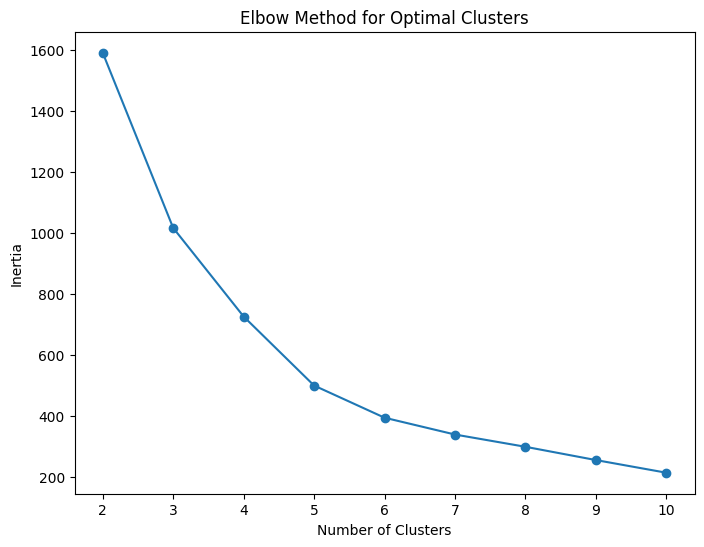

In [29]:
# Use the elbow method to find the optimal number of clusters (between 2 and 10)
inertia = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph to visualize the best number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


In [30]:
# Based on the elbow plot, choose an optimal number of clusters (e.g., 4 clusters)
optimal_clusters = 4

# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(data_scaled)

# Display the first few rows with the cluster assignments
print(data.head())


  CustomerID      CustomerName         Region  SignupDate TransactionID  \
0      C0001  Lawrence Carroll  South America  2022-07-10        T00015   
1      C0001  Lawrence Carroll  South America  2022-07-10        T00932   
2      C0001  Lawrence Carroll  South America  2022-07-10        T00085   
3      C0001  Lawrence Carroll  South America  2022-07-10        T00445   
4      C0001  Lawrence Carroll  South America  2022-07-10        T00436   

  ProductID      TransactionDate  Quantity  TotalValue   Price  Cluster  
0      P054  2024-01-19 03:12:55         2      114.60   57.30        3  
1      P022  2024-09-17 09:01:18         3      412.62  137.54        3  
2      P096  2024-04-08 00:01:00         2      614.94  307.47        0  
3      P083  2024-05-07 03:11:44         2      911.44  455.72        0  
4      P029  2024-11-02 17:04:16         3     1300.92  433.64        2  


In [31]:
# Davies-Bouldin Index (DB Index)
db_index = davies_bouldin_score(data_scaled, data['Cluster'])

# Silhouette Score
silhouette_avg = silhouette_score(data_scaled, data['Cluster'])

# Print the clustering metrics
print(f'Davies-Bouldin Index: {db_index}')
print(f'Silhouette Score: {silhouette_avg}')


Davies-Bouldin Index: 0.8147073741782886
Silhouette Score: 0.43480986399976573


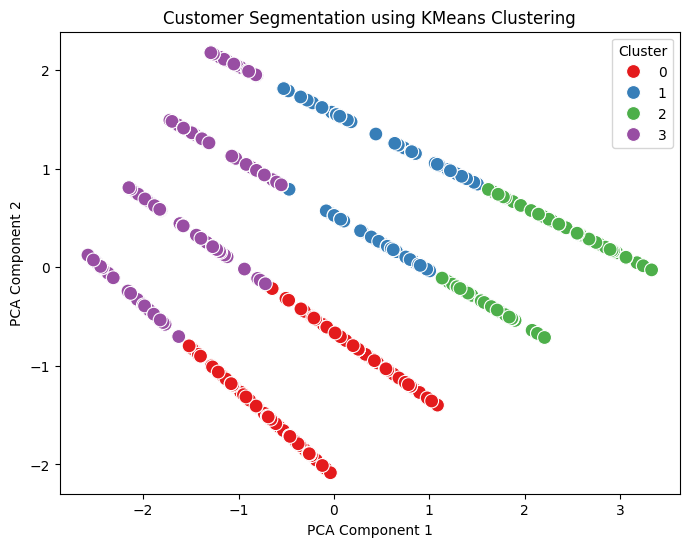

In [32]:
# Perform PCA for dimensionality reduction (to 2D)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data_scaled)

# Plot the clusters in 2D space
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=data['Cluster'], palette='Set1', s=100)
plt.title('Customer Segmentation using KMeans Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()
